# Exploring the model code

The model code is contained in the `wals_ml_engine` directory. The code's 
high-level functionality is implemented by the following files:

`mltrain.sh`
 * Launches various types of ML Engine jobs. This shell
      script accepts arguments for the location of the dataset file, the
      delimiter used to separate values in the file, and whether the data
      file has a header line. It's a best practice to create a script that
      automatically configures and executes ML Engine jobs.

`task.py`
 * Parses the arguments for the ML Engine job and executes
      training.

`model.py`
 * Loads the dataset.
 * Creates two sparse matrices from the data, one for  training and one for
      testing. Executes WALS on the training sparse matrix of ratings.

`wals.py`
 * Creates the WALS model.
 * Executes the WALS algorithm.
 * Calculates the root-mean-square error [RMSE](https://wikipedia.org/wiki/Root-mean-square_deviation) for a set of row/column factors and a ratings matrix.

## Let's run some code

Now we will run some of the code from `model.py` in this notebook, to help you understand it.

**Execute the following cell to import necessary python modules:**

In [1]:
import datetime
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
import tensorflow as tf

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
%bash
#pip install -r ../requirements.txt

In [2]:
from tensorflow.contrib.factorization.python.ops import factorization_ops
import sh
import math

ImportError: No module named sh

## The MovieLens data set

**Execute the following cell to download the MovieLens 100k data set:**

In [2]:
!curl -O 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
!unzip ml-100k.zip
!mkdir -p ../data
!cp ml-100k/u.data ../data/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4808k  100 4808k    0     0  1914k      0  0:00:02  0:00:02 --:--:-- 1914k
Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test       

**Let's take a look at the MovieLens data.** It consists of rows of individual user ratings of movies.  Each row consists of four elements: a unique user id, a unique 'item id' corresponding to a movie, a rating from 1-5, and a timestamp of when the rating was made.  Each row of data maps to a single entry in the ratings matrix:

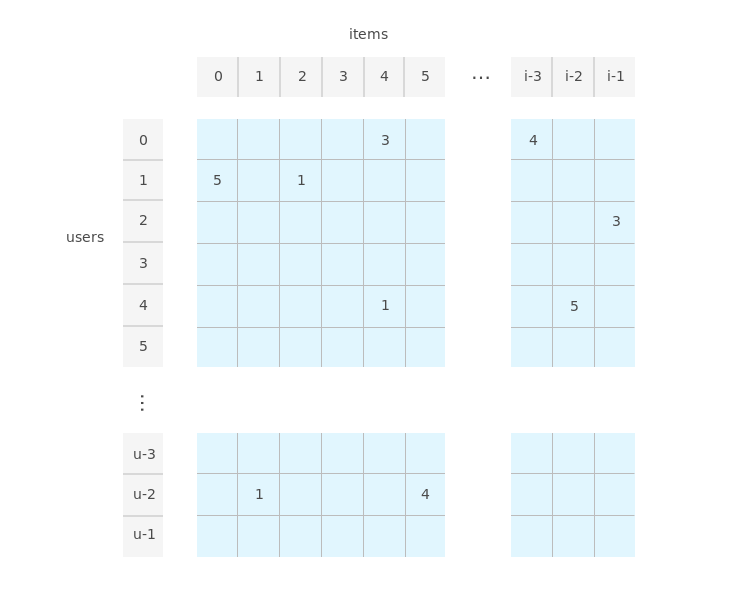

Let's inspect the contents of the file:

In [3]:
!head ../data/u.data

196	242	3	881250949
186	302	3	891717742
22	377	1	878887116
244	51	2	880606923
166	346	1	886397596
298	474	4	884182806
115	265	2	881171488
253	465	5	891628467
305	451	3	886324817
6	86	3	883603013


This model ignores the timestamp.  We will only make use of the **user id**, **item** (or movie) **id**, and **rating**.

## How the model preprocesses data

The model code performs data preprocessing to create a sparse ratings matrix and prepare it for matrix factorization. 

**This involves the following steps:**

 * The model code loads rows of data from a delimited text file, in this case the MovieLens data. 

**Execute this cell to read the MovieLens data set into a Pandas dataframe:**

In [4]:
input_file = '../data/u.data'
headers = ['user_id', 'item_id', 'rating', 'timestamp']
header_row = None
ratings_df = pd.read_csv(input_file,
                         sep='\t',
                         names=headers,
                         header=header_row,
                         dtype={
                           'user_id': np.int32,
                           'item_id': np.int32,
                           'rating': np.float32,
                           'timestamp': np.int32,
                         })

In [17]:
ratings_df.head()

,user_id,item_id,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


 * The code establishes a 0-indexed set of unique IDs for users and items. This guarantees that a unique ID corresponds to specific row and column indexes of the sparse ratings matrix.
 
**Let's find the number of unique users and movies:**

In [5]:
np_users = ratings_df.user_id.as_matrix()
np_items = ratings_df.item_id.as_matrix()
unique_users = np.unique(np_users)
unique_items = np.unique(np_items)

n_users = unique_users.shape[0]
n_items = unique_items.shape[0]

In [6]:
n_users

943

In [7]:
n_items

1682

The MovieLens 100k data uses 1-based IDs where the lowest index of the unique set is 1. But the TensorFlow code assumes a starting index of zero.  The code handles this **by converting the Pandas dataframe to a numpy array and subtracting one from each index:**

In [8]:
ratings = ratings_df.as_matrix(['user_id', 'item_id', 'rating'])
ratings[:,0] -= 1
ratings[:,1] -= 1

In [9]:
ratings

array([[1.950e+02, 2.410e+02, 3.000e+00],
       [1.850e+02, 3.010e+02, 3.000e+00],
       [2.100e+01, 3.760e+02, 1.000e+00],
       ...,
       [2.750e+02, 1.089e+03, 1.000e+00],
       [1.200e+01, 2.240e+02, 2.000e+00],
       [1.100e+01, 2.020e+02, 3.000e+00]])

 * The model code randomly selects a test set of ratings. By default, 10% of the ratings are chosen for the test set. These ratings are removed from the training set and will be used to evaluate the predictive accuracy of the user and item factors.

In [10]:
TEST_SET_RATIO = 10

test_set_size = len(ratings) / TEST_SET_RATIO
test_set_idx = np.random.choice(xrange(len(ratings)),
                                size=test_set_size, replace=False)
test_set_idx = sorted(test_set_idx)

ts_ratings = ratings[test_set_idx]
tr_ratings = np.delete(ratings, test_set_idx, axis=0)

In [ ]:
test_set_idx

In [12]:
ts_ratings

array([[223.,  28.,   3.],
       [224., 192.,   4.],
       [245., 200.,   5.],
       ...,
       [393., 379.,   4.],
       [933., 215.,   1.],
       [448., 119.,   1.]])

In [13]:
tr_ratings

array([[1.950e+02, 2.410e+02, 3.000e+00],
       [1.850e+02, 3.010e+02, 3.000e+00],
       [2.100e+01, 3.760e+02, 1.000e+00],
       ...,
       [2.750e+02, 1.089e+03, 1.000e+00],
       [1.200e+01, 2.240e+02, 2.000e+00],
       [1.100e+01, 2.020e+02, 3.000e+00]])

 * Finally, the code creates a `scipy` sparse matrix in coordinate form (`coo_matrix`) that includes the user and item indexes and ratings. The `coo_matrix` object acts as a wrapper for a sparse matrix. It also performs validation of the user and ratings indexes, checking for errors in preprocessing:

In [14]:
u_tr, i_tr, r_tr = zip(*tr_ratings)
tr_sparse = coo_matrix((r_tr, (u_tr, i_tr)), shape=(n_users, n_items))

u_ts, i_ts, r_ts = zip(*ts_ratings)
test_sparse = coo_matrix((r_ts, (u_ts, i_ts)), shape=(n_users, n_items))

In [15]:
tr_sparse

<943x1682 sparse matrix of type '<type 'numpy.float64'>'
	with 90000 stored elements in COOrdinate format>

In [16]:
test_sparse

<943x1682 sparse matrix of type '<type 'numpy.float64'>'
	with 10000 stored elements in COOrdinate format>

## How the WALS Algorithm is implemented in TensorFlow

You can read the [solution online](https://wikipedia.org/wiki/Root-mean-square_deviation) to understand how the WALS algorithm is implemented in TensorFlow.

In [18]:
# Import helpful libraries and setup our project, bucket, and region
import os

PROJECT = 'avid-grid-217112' # REPLACE WITH YOUR PROJECT ID
BUCKET = 'avid-grid-217112' # REPLACE WITH YOUR BUCKET NAME
REGION = 'asia-southeast1' # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

# do not change these
os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION

In [ ]:
%bash
gcloud  config  set project $PROJECT
gcloud config set compute/region $REGION

Copy the MovieLens datasets to the bucket using the gsutil tool:

In [ ]:
!gsutil cp -r ../data/u.data gs://{BUCKET}/data/u.data

How the WALS Algorithm is implemented in TensorFlow
After the data is preprocessed, the code passes the sparse training matrix into the TensorFlow WALS model to be factorized into row factor X and column factor Y.

The TensorFlow code that executes the model is actually simple, because it relies on the WALSModel class included in the contrib.factorization_ops module of TensorFlow.

A SparseTensor object is initialized with user IDs and items IDs as indices, and with the ratings as values. From wals.py:

In [52]:
LOG_RATINGS = 0
LINEAR_RATINGS = 1
LINEAR_OBS_W = 100.0

def wals_model(data, dim, reg, unobs, weights=False,
               wt_type=LINEAR_RATINGS, feature_wt_exp=None,
               obs_wt=LINEAR_OBS_W):
  """Create the WALSModel and input, row and col factor tensors.

  Args:
    data:           scipy coo_matrix of item ratings
    dim:            number of latent factors
    reg:            regularization constant
    unobs:          unobserved item weight
    weights:        True: set obs weights, False: obs weights = unobs weights
    wt_type:        feature weight type: linear (0) or log (1)
    feature_wt_exp: feature weight exponent constant
    obs_wt:         feature weight linear factor constant

  Returns:
    input_tensor:   tensor holding the input ratings matrix
    row_factor:     tensor for row_factor
    col_factor:     tensor for col_factor
    model:          WALSModel instance
  """
  row_wts = None
  col_wts = None

  num_rows = data.shape[0]
  num_cols = data.shape[1]

  if weights:
    assert feature_wt_exp is not None
    row_wts = np.ones(num_rows)
    col_wts = make_wts(data, wt_type, obs_wt, feature_wt_exp, 0)

  row_factor = None
  col_factor = None

  with tf.Graph().as_default():

    input_tensor = tf.SparseTensor(indices=zip(data.row, data.col),
                                   values=(data.data).astype(np.float32),
                                   dense_shape=data.shape)

    model = factorization_ops.WALSModel(num_rows, num_cols, dim,
                                        unobserved_weight=unobs,
                                        regularization=reg,
                                        row_weights=row_wts,
                                        col_weights=col_wts)

    # retrieve the row and column factors
    row_factor = model.row_factors[0]
    col_factor = model.col_factors[0]

  return input_tensor, row_factor, col_factor, model

In [28]:
def make_wts(data, wt_type, obs_wt, feature_wt_exp, axis):
  """Generate observed item weights.

  Args:
    data:             coo_matrix of ratings data
    wt_type:          weight type, LOG_RATINGS or LINEAR_RATINGS
    obs_wt:           linear weight factor
    feature_wt_exp:   logarithmic weight factor
    axis:             axis to make weights for, 1=rows/users, 0=cols/items

  Returns:
    vector of weights for cols (items) or rows (users)
  """
  # recipricol of sum of number of items across rows (if axis is 0)
  frac = np.array(1.0/(data > 0.0).sum(axis))

  # filter any invalid entries
  frac[np.ma.masked_invalid(frac).mask] = 0.0

  # normalize weights according to assumed distribution of ratings
  if wt_type == LOG_RATINGS:
    wts = np.array(np.power(frac, feature_wt_exp)).flatten()
  else:
    wts = np.array(obs_wt * frac).flatten()

  # check again for any numerically unstable entries
  assert np.isfinite(wts).sum() == wts.shape[0]
  return wts

In [25]:
DEFAULT_PARAMS = {
    'weights': True,
    'latent_factors': 5,
    'num_iters': 20,
    'regularization': 0.07,
    'unobs_weight': 0.01,
    'wt_type': 0,
    'feature_wt_factor': 130.0,
    'feature_wt_exp': 0.08,
    'delimiter': '\t',
    
}

dim = DEFAULT_PARAMS['latent_factors']
num_iters = DEFAULT_PARAMS['num_iters']
reg = DEFAULT_PARAMS['regularization']
unobs = DEFAULT_PARAMS['unobs_weight']
wt_type = DEFAULT_PARAMS['wt_type']
feature_wt_exp =DEFAULT_PARAMS['feature_wt_exp']
obs_wt = DEFAULT_PARAMS['feature_wt_factor']

In [29]:
 # generate model
input_tensor, row_factor, col_factor, model = wals_model(tr_sparse,
                                                                dim,
                                                                reg,
                                                                unobs,
                                                                DEFAULT_PARAMS['weights'],
                                                                wt_type,
                                                                feature_wt_exp,
                                                                obs_wt)


/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in divide


In [30]:
def simple_train(model, input_tensor, num_iterations):
  """Helper function to train model on input for num_iterations.

  Args:
    model:            WALSModel instance
    input_tensor:     SparseTensor for input ratings matrix
    num_iterations:   number of row/column updates to run

  Returns:
    tensorflow session, for evaluating results
  """
  sess = tf.Session(graph=input_tensor.graph)

  with input_tensor.graph.as_default():
    row_update_op = model.update_row_factors(sp_input=input_tensor)[1]
    col_update_op = model.update_col_factors(sp_input=input_tensor)[1]

    sess.run(model.initialize_op)
    sess.run(model.worker_init)
    for _ in xrange(num_iterations):
      sess.run(model.row_update_prep_gramian_op)
      sess.run(model.initialize_row_update_op)
      sess.run(row_update_op)
      sess.run(model.col_update_prep_gramian_op)
      sess.run(model.initialize_col_update_op)
      sess.run(col_update_op)

  return sess

In [54]:
def save_model(args, user_map, item_map, row_factor, col_factor):
  """Save the user map, item map, row factor and column factor matrices in numpy format.

  These matrices together constitute the "recommendation model."

  Args:
    args:         input args to training job
    user_map:     user map numpy array
    item_map:     item map numpy array
    row_factor:   row_factor numpy array
    col_factor:   col_factor numpy array
  """
  model_dir = os.path.join(args['output_dir'], 'model')

  # if our output directory is a GCS bucket, write model files to /tmp,
  # then copy to GCS
  gs_model_dir = None
  
  model_dir =  model_dir[:-1] if model_dir.endswith('/') else model_dir
  job_name = os.path.basename(model_dir)
  
  if model_dir.startswith('gs://'):
    gs_model_dir = model_dir
    model_dir = '/tmp/{0}'.format(job_name)

  #os.makedirs(model_dir)
  np.save(os.path.join(model_dir, 'user'), user_map)
  np.save(os.path.join(model_dir, 'item'), item_map)
  np.save(os.path.join(model_dir, 'row'), row_factor)
  np.save(os.path.join(model_dir, 'col'), col_factor)

  if gs_model_dir:
    sh.gsutil('cp', '-r', os.path.join(model_dir, '*'), gs_model_dir)


In [56]:
def get_rmse(output_row, output_col, actual):
  """Compute rmse between predicted and actual ratings.

  Args:
    output_row: evaluated numpy array of row_factor
    output_col: evaluated numpy array of col_factor
    actual: coo_matrix of actual (test) values

  Returns:
    rmse
  """
  mse = 0
  for i in xrange(actual.data.shape[0]):
    row_pred = output_row[actual.row[i]]
    col_pred = output_col[actual.col[i]]
    err = actual.data[i] - np.dot(row_pred, col_pred)
    mse += err * err
  mse /= actual.data.shape[0]
  rmse = math.sqrt(mse)
  return rmse

In [32]:
  # factorize matrix
session = simple_train(model, input_tensor, num_iters)

In [33]:
# evaluate output factor matrices
output_row = row_factor.eval(session=session)
output_col = col_factor.eval(session=session)

In [35]:
output_row.shape

(943, 5)

In [40]:
args = {'output_dir': ''}
args['output_dir']="gs://{}/model".format(BUCKET)

In [55]:
# save trained model to job directory
user_map=ratings[:,0]
item_map=ratings[:,1]
save_model(args, user_map, item_map, output_row, output_col)

In [59]:
  # log results
train_rmse =get_rmse(output_row, output_col, tr_sparse)
test_rmse = get_rmse(output_row, output_col, test_sparse)

In [61]:
print('train=',train_rmse)
print('test=',test_rmse)

('train=', 0.9319283584959055)
('test=', 1.0636285361429554)
